In [2]:
%matplotlib nbagg
import itertools
import numpy as np
import matplotlib.pyplot as plt
import numba
import h5py
import os
import collections

In [3]:
bin_paths = [
    "/home/clausen/Data/K2-IS/Capture52/Capture52_%d.bin" % i
    for i in range(1, 9)
]
HEADER_SIZE = 40
BLOCK_SIZE = 0x5758

In [4]:
@numba.jit(nopython=True)
def decode_uint12_le(inp, out):
    """
    decode bytes from bytestring ``inp`` as 12 bit into ``out``
    """
    o = 0
    for i in range(0, len(inp), 3):
        s = inp[i : i + 3]
        a = s[0] | (s[1] & 0x0F) << 8
        b = (s[1] & 0xF0) >> 4 | s[2] << 4
        out[o] = a
        out[o + 1] = b
        o += 2
    return out

In [5]:
class Sector:
    def __init__(self, fname, idx):
        self.fname = fname
        self.f = open(fname, "rb")
        self.idx = idx
        self.filesize = os.fstat(self.f.fileno()).st_size
        
    def seek(self, pos):
        self.f.seek(pos)
        
    def read(self, size):
        return self.f.read(size)

In [16]:
class DataBlock:
    header_dtype = [
        ('sync', (bytes, 4)),
        ('padding1', (bytes, 4)),
        ('version', '>u1'),
        ('padding2', (bytes, 7)),
        ('block_count', '>u4'),
        ('width', '>u2'),
        ('height', '>u2'),
        ('frame_id', '>u4'),
        ('pixel_x_start', '>u2'),  # first pixel x coordinate within sector
        ('pixel_y_start', '>u2'),  # first pixel y coordinate within sector
        ('pixel_x_end', '>u2'),  # last pixel x coordinate within sector
        ('pixel_y_end', '>u2'),  # last pixel y coordinate within sector
        ('block_size', '>u4'),
    ]
    
    def __init__(self, offset, sector):
        self.offset = offset
        self.sector = sector
        self._header_raw = None
        self._data_raw = None
        
    @property
    def is_valid(self):
        # TODO: more checks        
        return (
            self.sector.filesize >= self.offset + BLOCK_SIZE
            and self.header['width'] == 256
            and self.header['height'] == 1860
            # and self._header_raw['sync'][0] == 0xFFFF0055
        )
    
    @property
    def header(self):
        if self._header_raw is None:
            self.sector.seek(self.offset)
            self._header_raw = np.fromfile(self.sector.f, dtype=self.header_dtype, count=1)
        header = {}
        for field, dtype in self.header_dtype:
            if type(dtype) != str:
                continue
            header[field] = self._header_raw[field][0]
        return header
    
    @property
    def pixel_data_raw(self):
        if self._data_raw is None:
            self.sector.seek(self.offset + HEADER_SIZE)
            self._data_raw = self.sector.read(BLOCK_SIZE - HEADER_SIZE)
        return self._data_raw
    
    def readinto(self, out):
        out = out.reshape(930 * 16)
        return decode_uint12_le(inp=self.pixel_data_raw, out=out).reshape(930, 16)
    
    @property
    def pixel_data(self):
        arr = np.zeros((930 * 16), dtype="uint16")
        self.readinto(arr)
        return arr.reshape(930, 16)
    
    def copy_to_frame(self, frame):
        sector_width = 256
        x_offset = self.sector.idx * sector_width
        h = self.header
        frame[
            h['pixel_y_start']:h['pixel_y_end'] + 1,
            h['pixel_x_start'] + x_offset:h['pixel_x_end'] + 1 + x_offset,
        ] = self.pixel_data
    
    def __repr__(self):
        h = self.header
        return "<DataBlock for frame=%d x=%d:%d y=%d:%d" % (
            h['frame_id'],
            h['pixel_x_start'], h['pixel_x_end'],
            h['pixel_y_start'], h['pixel_y_end'],
        )

In [17]:
def read_blocks(fname, sector_idx):
    offset = 0
    sector = Sector(fname=fname, idx=sector_idx)
    while True:
        yield DataBlock(offset=offset, sector=sector)
        offset += BLOCK_SIZE

In [18]:
num_frames = 34 * 10  # 34 * 34

In [22]:
with h5py.File(os.path.expanduser("~/k2test.h5"), "w") as destf:
    g = destf.create_group("data")
    ds = g.create_dataset("frames", shape=(num_frames, 1860, 2048), chunks=(1, 930, 16), dtype='uint16')
    sectors = [
        Sector(fname=fname, idx=idx)
        for (idx, fname) in enumerate(bin_paths)
    ]
    offsets = collections.defaultdict(lambda: 0)
    for frame in range(num_frames):
        frame_id = None
        for sector in sectors:
            for block_idx in range(32):
                offset = offsets[sector.idx]
                block = DataBlock(offset=offset, sector=sector)
                block.header
                # assert block.is_valid
                # if frame_id is None:
                #     frame_id = block.header['frame_id']
                # else:
                #     if frame_id != block.header['frame_id']:
                #         raise ValueError("desync? %d != %d" % (frame_id, block.header['frame_id']))
                offsets[sector.idx] += BLOCK_SIZE

                try:
                    # block.copy_to_frame(frame=ds[frame])
                    sector_width = 256
                    x_offset = block.sector.idx * sector_width
                    h = block.header
                    ds[
                        frame,
                        h['pixel_y_start']:h['pixel_y_end'] + 1,
                        h['pixel_x_start'] + x_offset:h['pixel_x_end'] + 1 + x_offset,
                    ] = block.pixel_data
                    
                except Exception:
                    raise

<IPython.core.display.Javascript object>


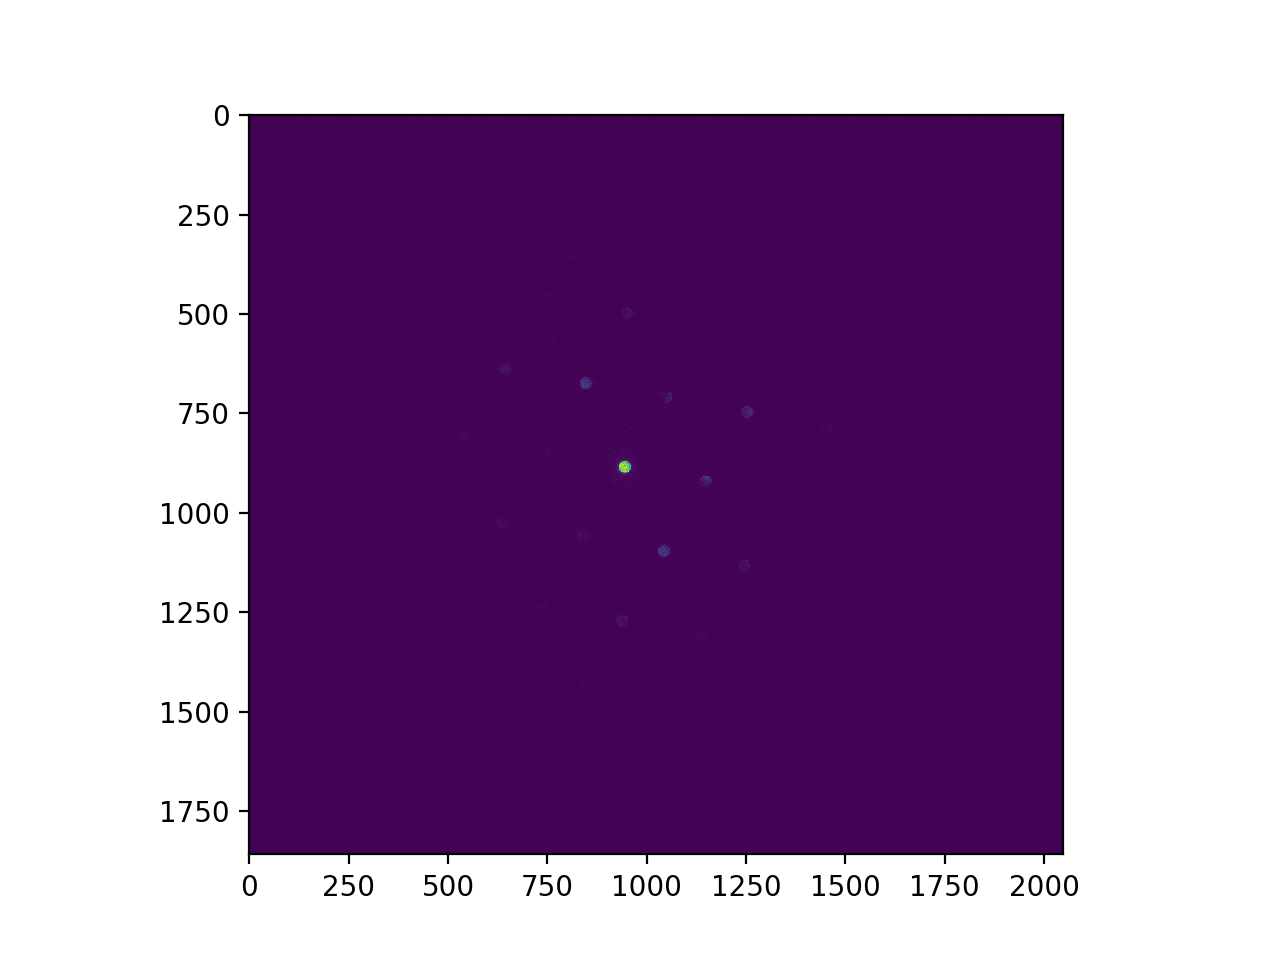

In [28]:
with h5py.File(os.path.expanduser("~/k2test.h5"), "r") as f:
    ds = f['data/frames']
    frame = ds[250]
    fig, axes = plt.subplots()
    axes.imshow(frame)